In [3]:
## Import packages

using Statistics
using Pkg
using LinearAlgebra
using StatsBase
using Random
using JLD
using Plots
using Distributions
using JSON
Pkg.add("ColorSchemes")
using ColorSchemes
# using PyCall
# nx = pyimport("networkx")

include("helper_functions.jl")

 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]


read_config (generic function with 1 method)

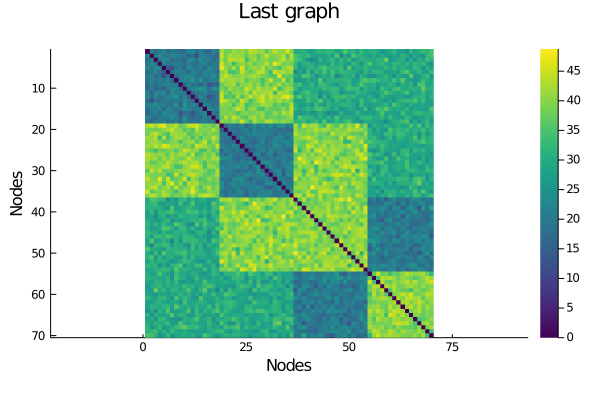

In [46]:
# import R and theta_w
R = [1 2 2 2; 2 1 2 1; 1 2 2 1; 1 2 1 2]
theta_w = [10 2; 20 2]
nNodes = 70
groupSizes = Int.([ceil(nNodes/4) ceil(nNodes/4) ceil(nNodes/4) nNodes-3*ceil(nNodes/4)])

# Build adj by column
function make_wsbm(nNodes, R, theta_w, groupSizes)
    ### Based on the Weighted Stochastic Block Model defined in:
    ### Aicher, Christopher Vinyu, "The Weighted Stochastic Block Model" (2014). Applied Mathematics Graduate Theses & Dissertations. 50.
    ### https://scholar.colorado.edu/appm_gradetds/50
    ###
    ### This code is adapted from the original matlab code functions generateEdges and Edge2Adj within the matlab package
    ### found here: http://tuvalu.santafe.edu/~aaronc/wsbm/
    ### Unlike the original code, the below assumes the edge weights come from a Normal distribution and that all
    ### edges will exist in the final graph (no sparsity control).

    adj = zeros((nNodes,0))
    for (j,col) in enumerate(eachcol(R))
        newcol = zeros((0,groupSizes[j]))

        for (i,row) in enumerate(eachrow(R))

            block = rand(Normal(theta_w[R[i,j],1],theta_w[R[i,j],2]),(groupSizes[i],groupSizes[j]))
            newcol = [newcol; block]

        end

        adj = [adj newcol]

    end

    # Make symmetric
    adj = adj+adj'

    # Set diagonal to 0
    adj[diagind(adj)].=0

    # Set any weight <0 to 0
    adj[adj.<0].=0
    
    return adj
end

adj = make_wsbm(nNodes, R, theta_w, groupSizes)

p1a = heatmap(adj,yflip = true, aspect_ratio=:equal, grid = false, c = :viridis)
    title!("Last graph")
    ylabel!("Nodes")
    xlabel!("Nodes")



In [28]:
zeros((0,5))

0×5 Array{Float64,2}

In [4]:
# Define parameters

# Read from config file
config_file = "config090120.json"
config = read_config("$(homedir())/configs/$(config_file)")

const NNODES = config["NNODES"]
const MAXDIM = config["MAXDIM"]
const NREPS = config["NREPS"]
const DATE_STRING = config["DATE_STRING"]
const SAVETAIL = config["SAVETAIL_graphInfo"]
const read_dir = "$(homedir())/$(config["read_dir_graphs"])/$(NNODES)nodes"

# Locate graph files
graph_files = filter(x->occursin(DATE_STRING,x), readdir(read_dir))
println("Located the following graph files:")
for graph_file in graph_files
    println(graph_file)
end
model_names = [split(graph_file,"_")[1] for graph_file in graph_files]

Located the following graph files:
IID_70nodes_50reps_090120_graphs.jld
IID_70nodes_50reps_090120_graphs_thresh005_edge121.jld
IID_70nodes_50reps_090120_graphs_thresh015_edge363.jld
IID_70nodes_50reps_090120_graphs_thresh01_edge242.jld
IID_70nodes_50reps_090120_graphs_thresh02_edge483.jld
IID_70nodes_50reps_090120_graphs_thresh03_edge725.jld
IID_70nodes_50reps_090120_graphs_thresh04_edge966.jld
IID_70nodes_50reps_090120_graphs_thresh05_edge1208.jld
IID_70nodes_50reps_090120_graphs_thresh06_edge1449.jld
associative_70nodes_50reps_10_10_2_2_09_05_090120_graphs.jld
associative_70nodes_50reps_10_10_2_2_09_05_090120_graphs_thresh005_edge121.jld
associative_70nodes_50reps_10_10_2_2_09_05_090120_graphs_thresh015_edge363.jld
associative_70nodes_50reps_10_10_2_2_09_05_090120_graphs_thresh01_edge242.jld
associative_70nodes_50reps_10_10_2_2_09_05_090120_graphs_thresh02_edge483.jld
associative_70nodes_50reps_10_10_2_2_09_05_090120_graphs_thresh03_edge725.jld
associative_70nodes_50reps_10_10_2_2_09

90-element Array{SubString{String},1}:
 "IID"        
 "IID"        
 "IID"        
 "IID"        
 "IID"        
 "IID"        
 "IID"        
 "IID"        
 "IID"        
 "associative"
 "associative"
 "associative"
 "associative"
 ⋮            
 "randomGeom" 
 "randomGeom" 
 "randomGeom" 
 "ringLattice"
 "ringLattice"
 "ringLattice"
 "ringLattice"
 "ringLattice"
 "ringLattice"
 "ringLattice"
 "ringLattice"
 "ringLattice"

In [5]:
for graph_file in graph_files
    
    graph_dict = load("$(read_dir)/$(graph_file)")
    weighted_graph_array = graph_dict["weighted_graph_array_noise"]

    nReps = size(weighted_graph_array)[3]
    G_end = weighted_graph_array[:,:,nReps]
    G_avg = dropdims(mean(weighted_graph_array, dims=3), dims=3)

    p1a = heatmap(G_end,yflip = true, aspect_ratio=:equal, grid = false, c = :viridis)
    title!("Last graph")
    ylabel!("Nodes")
    xlabel!("Nodes")

    p1b = heatmap(G_avg,yflip = true, aspect_ratio=:equal, grid=false, c = :viridis)
    title!("Average graph")
    ylabel!("Nodes")
    xlabel!("Nodes")

    # Edge weight distributions
    p1c = histogram([G_end...], legend = false, c=:gray, alpha = 0.3)
    title!("Last graph edge weight distribution")
    ylabel!("Frequency")
    xlabel!("Edge weight")

    p1d = histogram([weighted_graph_array...], legend = false, c=:gray, alpha = 0.3)
    title!("All graphs edge weight distribution")
    ylabel!("Frequency")
    xlabel!("Edge weight")

    # Degree distributions
    p1e = histogram([sum(G_end, dims=1)...], legend = false, c=:gray, alpha = 0.3)
    title!("Strength distribution last graph")
    ylabel!("Frequency")
    xlabel!("Node strength")

    p1f = histogram([sum(weighted_graph_array, dims=1)...], legend = false, c=:gray, alpha = 0.3)
    title!("Strength distribution all graphs")
    ylabel!("Frequency")
    xlabel!("Node strength")

    # Graph metrics
    clustering = zeros(1,nReps)
    modularity = zeros(1,nReps)


    for rep in 1:nReps

        g = nx.from_numpy_matrix(weighted_graph_array[:,:,rep], parallel_edges=false)
        clustering[1, rep] = nx.average_clustering(g, weight = "weight")
        modularity[1, rep] = nx.algorithms.community.modularity(g, nx.algorithms.community.label_propagation_communities(g))

    end


    p1g = histogram([clustering...], legend=false, c=:gray, alpha = 0.3)
    title!("Average clustering (all graphs)")
    xlabel!("Avg. clustering")
    ylabel!("Frequency")

    p1h = histogram([modularity...], legend=false, c=:gray, alpha = 0.3)
    title!("Modularity (all graphs)")
    xlabel!("Modularity")
    ylabel!("Frequency")


    plot(p1a, p1b, p1c, p1d, p1e, p1f, p1g, p1h, layout = (4, 2), size = (700,1100))
    savefig("../figures/$(replace(graph_file, "_graphs.jld" => ""))_$(NAMETAG).pdf")
end



KeyError: KeyError: key "weighted_graph_array_noise" not found